### alpha-diversity analysis
---

In [4]:
#setworking directory to AbioticAraMicrobe/
setwd('../')

In [16]:
# load packages
library(phyloseq)
library(ggplot2)
library(dplyr)
library(ggpubr)
library(FSA)
library(rcompanion)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




----
### alpha-diversity analysis for bacteria

[1] 15

[1] TRUE


	Shapiro-Wilk normality test

data:  rich_sample$Shannon
W = 0.97323, p-value = 5.273e-10


Comparison,Z,P.unadj,P.adj
<chr>,<dbl>,<dbl>,<dbl>
ERG - EY,-1.1430867,0.253002582,0.47437984
ERG - JUG,-2.4044968,0.016194749,0.08097375
EY - JUG,-1.3381203,0.180857216,0.38755118
ERG - K69,-2.0457887,0.040777163,0.15291436
EY - K69,-1.1189048,0.263180735,0.43863456
JUG - K69,0.0193524,0.984559984,0.98455998
ERG - PFN,-2.8212964,0.004782998,0.03587249
EY - PFN,-1.8929182,0.058368754,0.14592189
JUG - PFN,-0.7097944,0.477831620,0.71674743


Group,Letter,MonoLetter
<chr>,<chr>,<chr>
ERG,b,b
EY,ab,ab
JUG,ab,ab
K69,ab,ab
PFN,a,a
WH,a,a


[1] "Bacterial alpha diversity plots"


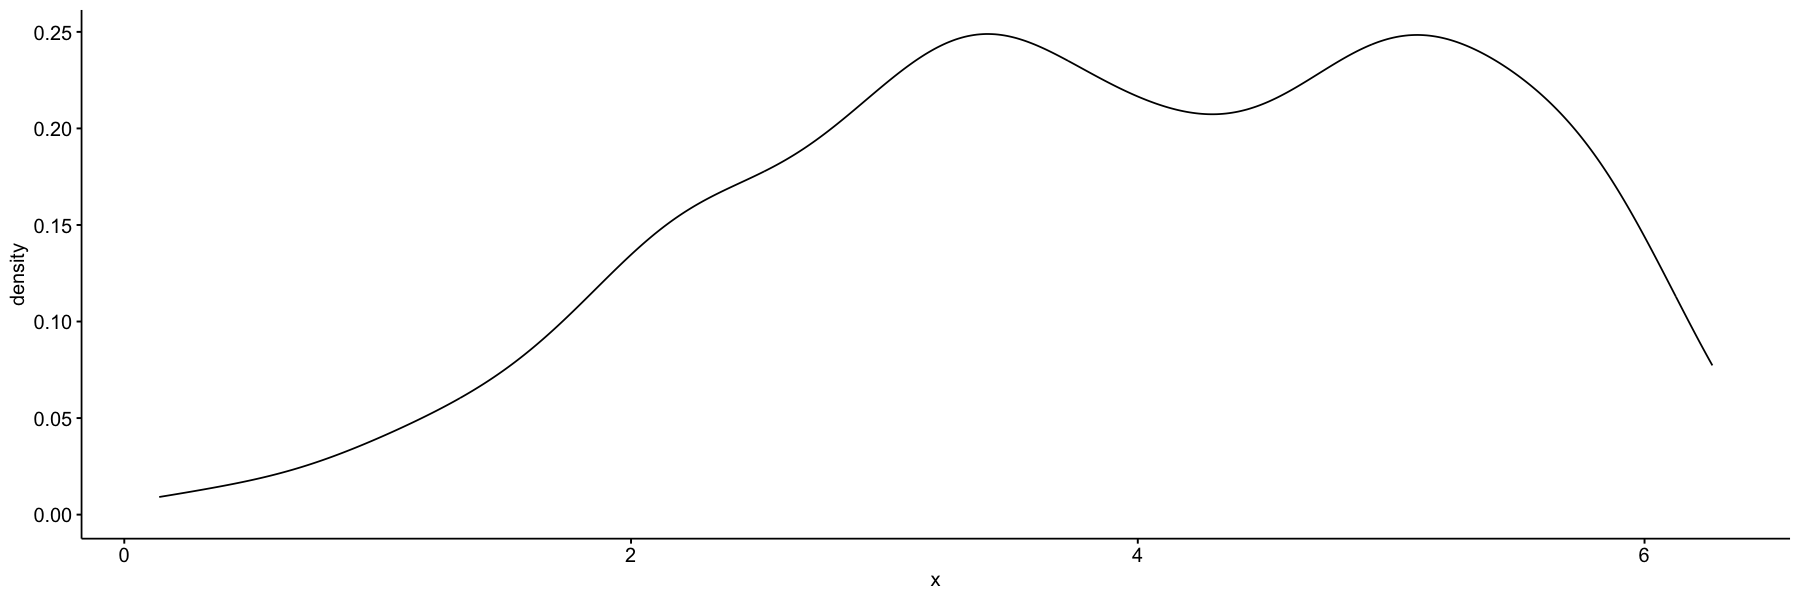

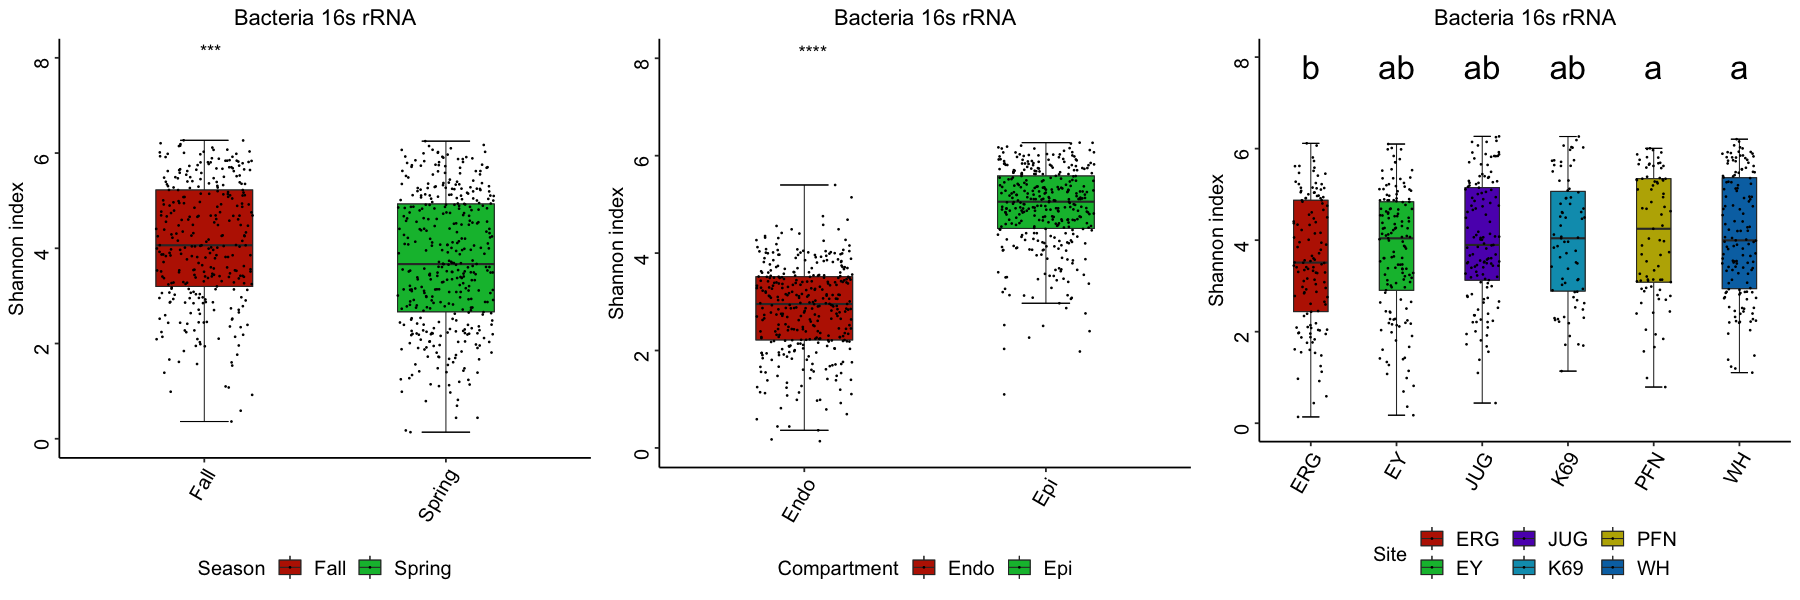

In [18]:
plot_list = list() # # list for saving plot
color = c("#bb2200","#00bb3b","#5e00bb" ,"#009cbb"  ,  "#bbaf00" , "#0072B2", "#D55E00", "#CC79A7") #color for plots
#---------------------------------------------------------------------------------------------

#Bacteria alpha diversity
#open otu table
Otu1 = read.table("data/DataClean/BV5Otu.txt", header = T , check.names = F , stringsAsFactors = F)
rownames(Otu1) = Otu1$Samplenumber
n = which(colnames(Otu1)=='Otu000002')  
n
sam_otu = Otu1[-c(1:14)] #n-1 
sam_otu = sam_otu[rowSums(sam_otu)!=0,]
sample = Otu1[c(1:14)] #n-1
sample = sample[rownames(sample) %in% rownames(sam_otu),]
identical(row.names(sample),row.names(sam_otu)) 

#make phyloseq input files
otusam <- otu_table(sam_otu , taxa_are_rows = FALSE,errorIfNULL = TRUE)
samples <- sample_data(sample)
file <- phyloseq(otusam,samples)
#---------------------------------------------------------------------------------------------
#mesure alpha diversity
rich = estimate_richness(file,measures = c("Observed", "Chao1", "Shannon"))
rich = select(rich , -c(3))
rich1 = merge(rich,data.frame(sample_data(file)),by=0)
rich1 = select(rich1 , -c(1))
rich_sample = rich1
rich_sample$Groups = paste(rich_sample$Compartment , rich_sample$Season , sep = "_")
rich_sample$Groups = as.factor(rich_sample$Groups)
#cheack normality
ggdensity(rich_sample$Shannon) #not normal
shapiro.test(rich_sample$Shannon) #not normal

# plot variables with 2 groups
counter = 0
variable = c("Season" , 'Compartment')
for (i in 1: length(variable)){
  counter = counter + 1
  var = variable[i]
  Div = "Shannon"
  p <- ggplot( rich_sample, aes_string(x = var , y = Div , fill=var))  + 
    geom_boxplot( outlier.shape=NA ,width=0.4 , lwd = 0.3 , 
                  position = position_dodge(width=6))  +
    stat_boxplot(aes(ymin = ..lower.., ymax = ..upper..) ,outlier.shape=NA ,width=0.4 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymin = ..ymax..), width=0.2 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymax = ..ymin..) ,width=0.2,lwd = 0.3) +
    geom_jitter(alpha = 1 , color = "black" , position = position_jitter(width = 0.2) , size = 0.1) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 12), 
          axis.text.y = element_text(angle=90, hjust=1 , size = 12 , colour="black" ) , 
          axis.title.y =  element_text(angle=90, size = 12) ,
          axis.title.x = element_blank() ,
          legend.position="bottom",
          legend.title = element_text(colour="black", size=12),
          legend.text = element_text(colour="black", size=12),
          plot.title = element_text(hjust = 0.5)) + ylim(-0.002,8) + 
    stat_compare_means(label = "p.signif", method = "wilcox.test") +
    scale_fill_manual(values = color) + labs(title="Bacteria 16s rRNA", y = "Shannon index")
  plot_list[[counter]] = p 
}

# for more than 2 groups variables use dunnTest to compaire the groups
DT = dunnTest(Shannon ~ as.factor(Site),data=rich_sample,method="bh") 
PT = DT$res
PT
group_data <- cldList(P.adj ~ Comparison,
                      data = PT,
                      threshold = 0.05 , reverse = 'TRUE') 
group_data

group_data$max = max(rich_sample$Shannon + 1)
colnames(group_data) = c("Site","Letter", "MonoLetter", "max")


#plot more than 2 groups
variable = c("Site")
for (i in 1: length(variable)){
  counter = counter + 1
  var = variable[i]
  Div = "Shannon"
  p <- ggplot( rich_sample, aes_string(x = var , y = Div , fill=var))  + 
    geom_boxplot( outlier.shape=NA ,width=0.4 , lwd = 0.3 , 
                  position = position_dodge(width=6))  +
    stat_boxplot(aes(ymin = ..lower.., ymax = ..upper..) ,outlier.shape=NA ,width=0.4 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymin = ..ymax..), width=0.2 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymax = ..ymin..) ,width=0.2,lwd = 0.3) +
    geom_jitter(alpha = 1 , color = "black" , position = position_jitter(width = 0.2) , size = 0.1) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 12), 
          axis.text.y = element_text(angle=90, hjust=1 , size = 12 , colour="black" ) , 
          axis.title.y =  element_text(angle=90, size = 12) ,
          axis.title.x = element_blank() ,
          legend.position="bottom",
          legend.title = element_text(colour="black", size=12),
          legend.text = element_text(colour="black", size=12),
          plot.title = element_text(hjust = 0.5)) + ylim(-0.002,8) + 
    geom_text(data=group_data,aes(x=Site,y=max,label=Letter),position = position_dodge(width = 0.9), size = 7 , vjust=-0.5 ) +
    scale_fill_manual(values = color) + labs(title="Bacteria 16s rRNA", y = "Shannon index")
  plot_list[[counter]] = p 
}

options(repr.plot.width=15, repr.plot.height=5)
print('Bacterial alpha diversity plots')
grid.arrange(grobs = plot_list[c(1:3)], nrow = 1, ncol = 3 , align="hv" )

---
### alpha-diversity analysis for fungi

[1] 15

[1] TRUE


	Shapiro-Wilk normality test

data:  rich_sample$Shannon
W = 0.98938, p-value = 6.89e-05


Comparison,Z,P.unadj,P.adj
<chr>,<dbl>,<dbl>,<dbl>
ERG - EY,1.2424155,0.2140832991,0.356805498
ERG - JUG,-2.2279370,0.0258847194,0.097067698
EY - JUG,-3.5966311,0.0003223652,0.004835478
ERG - K69,-1.5680732,0.1168640555,0.292160139
EY - K69,-2.6925961,0.0070898098,0.053173574
JUG - K69,0.3451951,0.7299476697,0.782086789
ERG - PFN,-1.2463413,0.2126391152,0.398698341
EY - PFN,-2.3901355,0.0168421558,0.084210779
JUG - PFN,0.7188340,0.4722431788,0.590303974


Group,Letter,MonoLetter
<chr>,<chr>,<chr>
ERG,ab,ab
EY,b,b
JUG,a,a
K69,ab,ab
PFN,ab,ab
WH,ab,ab


[1] "Fungal alpha diversity plots"


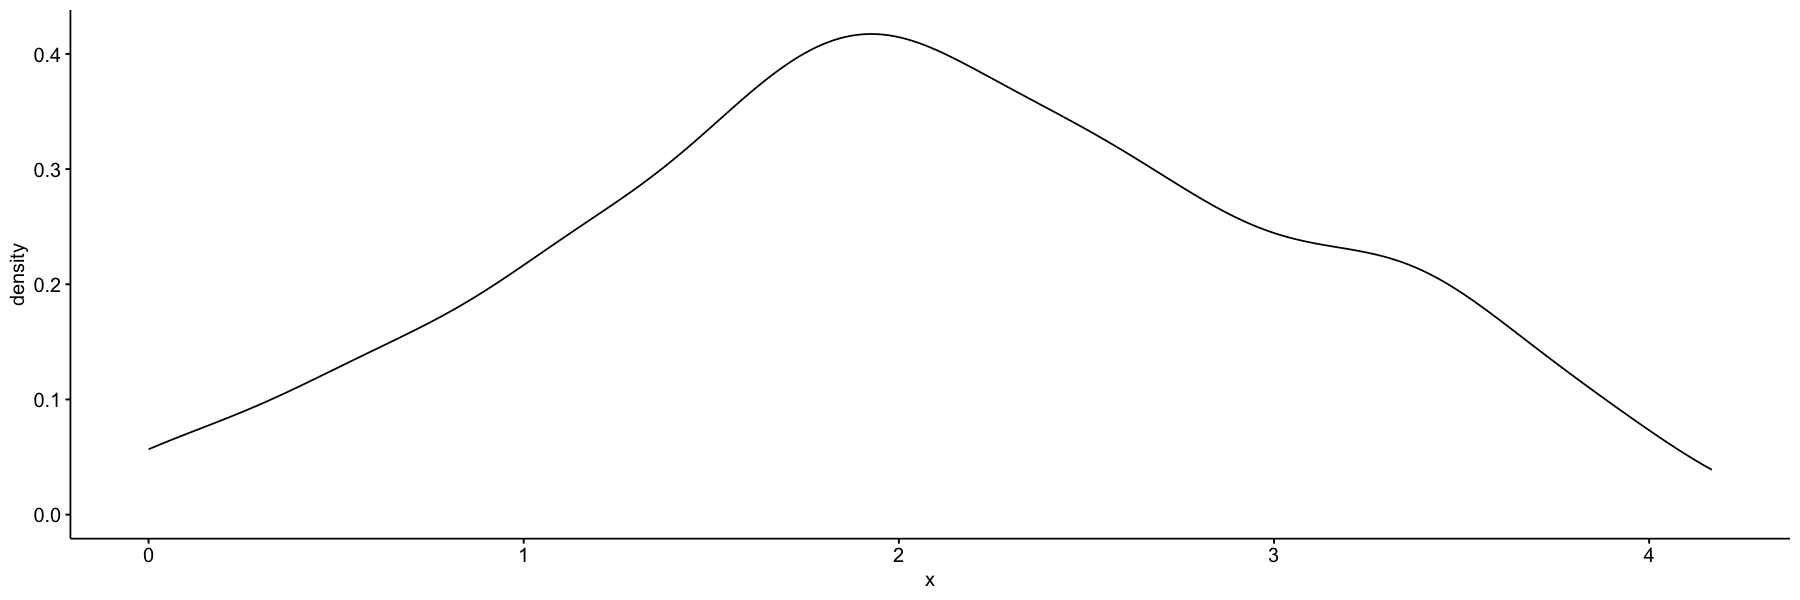

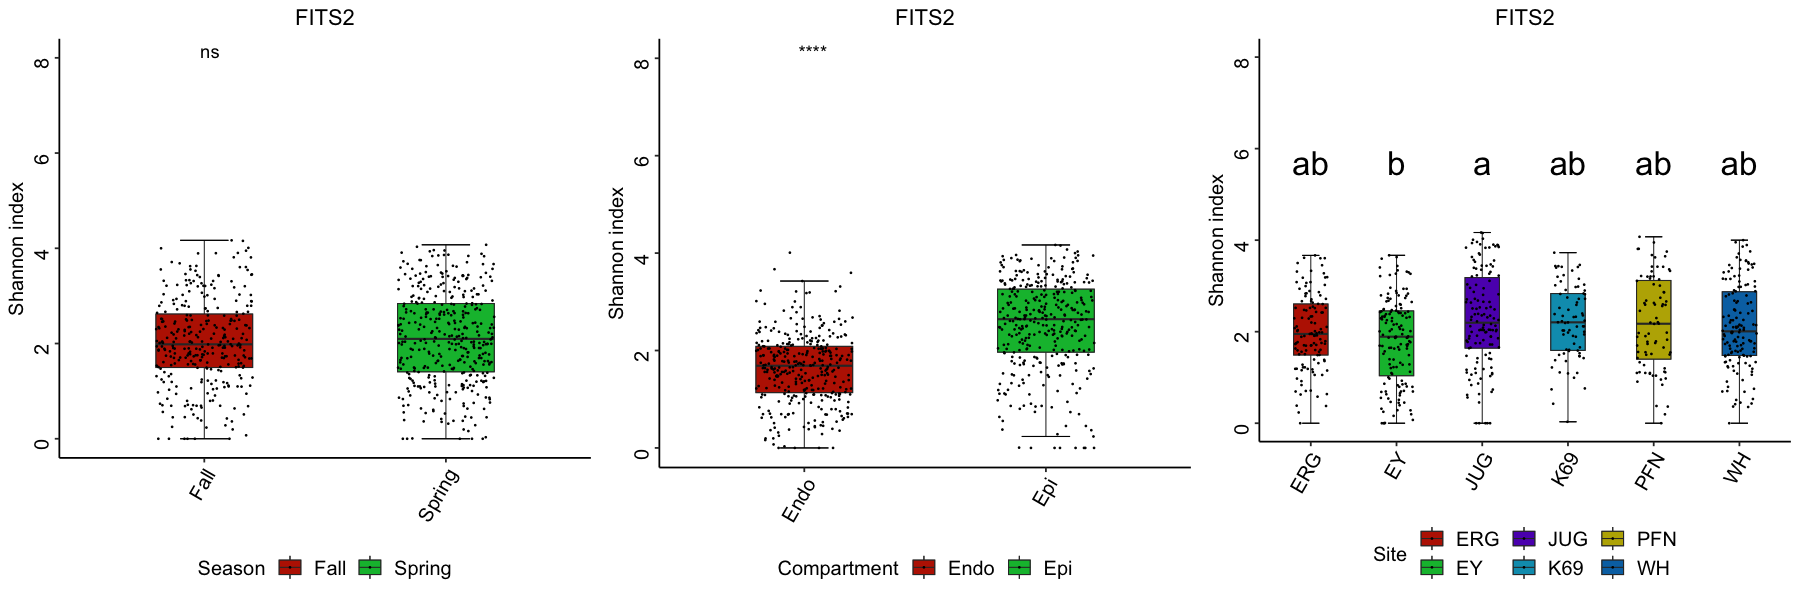

In [19]:
#fungi

Otu1 = read.table("data/DataClean/FITS2Otu.txt", header = T , check.names = F , stringsAsFactors = F)
rownames(Otu1) = Otu1$Samplenumber
n = which(colnames(Otu1)=='Otu00002') 
n
#---------------------------`------------------------------------------------------------------
sam_otu = Otu1[-c(1:14)] #n-1
sam_otu = sam_otu[rowSums(sam_otu)!=0,]
sample = Otu1[c(1:14)] #n-1
sample = sample[rownames(sample) %in% rownames(sam_otu),]
identical(row.names(sample),row.names(sam_otu)) 
#make phyloseq input files

#otu-sample matrix
#phloseqfiles
otusam <- otu_table(sam_otu , taxa_are_rows = FALSE,errorIfNULL = TRUE)
samples <- sample_data(sample)
file <- phyloseq(otusam,samples)
#---------------------------------------------------------------------------------------------


rich = estimate_richness(file,measures = c("Observed", "Chao1", "Shannon"))
rich = select(rich , -c(3))
rich1 = merge(rich,data.frame(sample_data(file)),by=0)
rich1 = select(rich1 , -c(1))
rich_sample = rich1
rich_sample$Groups = paste(rich_sample$Compartment , rich_sample$Season , sep = "_")
rich_sample$Groups = as.factor(rich_sample$Groups)
ggdensity(rich_sample$Shannon) #not normal
shapiro.test(rich_sample$Shannon) #not normal
####with letter final
counter = 3
variable = c("Season" , 'Compartment')
for (i in 1: length(variable)){
  counter = counter + 1
  var = variable[i]
  Div = "Shannon"
  p <- ggplot( rich_sample, aes_string(x = var , y = Div , fill=var))  + 
    geom_boxplot( outlier.shape=NA ,width=0.4 , lwd = 0.3 , 
                  position = position_dodge(width=6))  +
    stat_boxplot(aes(ymin = ..lower.., ymax = ..upper..) ,outlier.shape=NA ,width=0.4 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymin = ..ymax..), width=0.2 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymax = ..ymin..) ,width=0.2,lwd = 0.3) +
    geom_jitter(alpha = 1 , color = "black" , position = position_jitter(width = 0.2) , size = 0.1) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 12), 
          axis.text.y = element_text(angle=90, hjust=1 , size = 12 , colour="black" ) , 
          axis.title.y =  element_text(angle=90, size = 12) ,
          axis.title.x = element_blank() ,
          legend.position="bottom",
          legend.title = element_text(colour="black", size=12),
          legend.text = element_text(colour="black", size=12),
          plot.title = element_text(hjust = 0.5)) + ylim(-0.002,8) + 
    stat_compare_means(label = "p.signif", method = "wilcox.test") +
    scale_fill_manual(values = color) + labs(title="FITS2", y = "Shannon index")
  plot_list[[counter]] = p 
}

DT = dunnTest(Shannon ~ as.factor(Site),data=rich_sample,method="bh") 
PT = DT$res
PT
group_data <- cldList(P.adj ~ Comparison,
                      data = PT,
                      threshold = 0.05 , reverse = 'TRUE') 
group_data

group_data$max = max(rich_sample$Shannon + 1)
colnames(group_data) = c("Site","Letter", "MonoLetter", "max")

variable = c("Site")
for (i in 1: length(variable)){
  counter = counter + 1
  var = variable[i]
  Div = "Shannon"
  p <- ggplot( rich_sample, aes_string(x = var , y = Div , fill=var))  + 
    geom_boxplot( outlier.shape=NA ,width=0.4 , lwd = 0.3 , 
                  position = position_dodge(width=6))  +
    stat_boxplot(aes(ymin = ..lower.., ymax = ..upper..) ,outlier.shape=NA ,width=0.4 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymin = ..ymax..), width=0.2 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymax = ..ymin..) ,width=0.2,lwd = 0.3) +
    geom_jitter(alpha = 1 , color = "black" , position = position_jitter(width = 0.2) , size = 0.1) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 12), 
          axis.text.y = element_text(angle=90, hjust=1 , size = 12 , colour="black" ) , 
          axis.title.y =  element_text(angle=90, size = 12) ,
          axis.title.x = element_blank() ,
          legend.position="bottom",
          legend.title = element_text(colour="black", size=12),
          legend.text = element_text(colour="black", size=12),
          plot.title = element_text(hjust = 0.5)) + ylim(-0.002,8) + 
    geom_text(data=group_data,aes(x=Site,y=max,label=Letter),position = position_dodge(width = 0.9), size = 7 , vjust=-0.5 ) +
    scale_fill_manual(values = color) + labs(title="FITS2", y = "Shannon index")
  plot_list[[counter]] = p 
}


options(repr.plot.width=15, repr.plot.height=5)
print('Fungal alpha diversity plots')
grid.arrange(grobs = plot_list[c(4:6)], nrow = 1, ncol = 3 , align="hv" )

---
### alpha-diversity analysis for eukaryotes

[1] 15

[1] TRUE


	Shapiro-Wilk normality test

data:  rich_sample$Shannon
W = 0.95589, p-value = 1.25e-13


Comparison,Z,P.unadj,P.adj
<chr>,<dbl>,<dbl>,<dbl>
ERG - EY,-1.11893875,2.631663e-01,0.3289578356
ERG - JUG,-3.13531787,1.716680e-03,0.0128750990
EY - JUG,-2.11159587,3.472113e-02,0.0868028176
ERG - K69,-2.67451614,7.483717e-03,0.0224511521
EY - K69,-1.77699954,7.556831e-02,0.1619321032
JUG - K69,0.02436499,9.805615e-01,0.9805614742
ERG - PFN,-4.00309390,6.251947e-05,0.0009377921
EY - PFN,-3.12507580,1.777592e-03,0.0088879623
JUG - PFN,-1.26886295,2.044899e-01,0.3067349228


Group,Letter,MonoLetter
<chr>,<chr>,<chr>
ERG,c,c
EY,bc,bc
JUG,ab,ab
K69,ab,ab
PFN,a,a
WH,ab,ab


[1] "Eukaryotes alpha diversity plots"


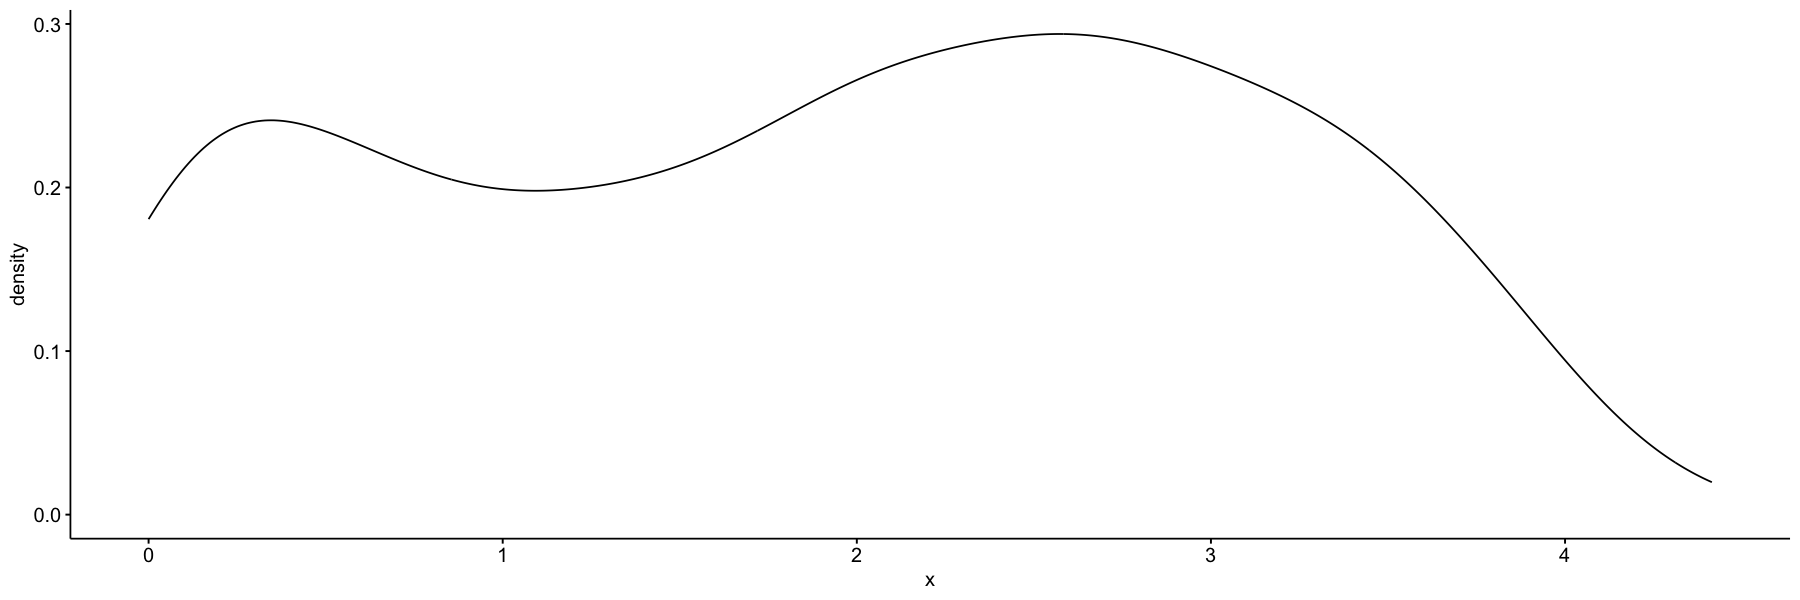

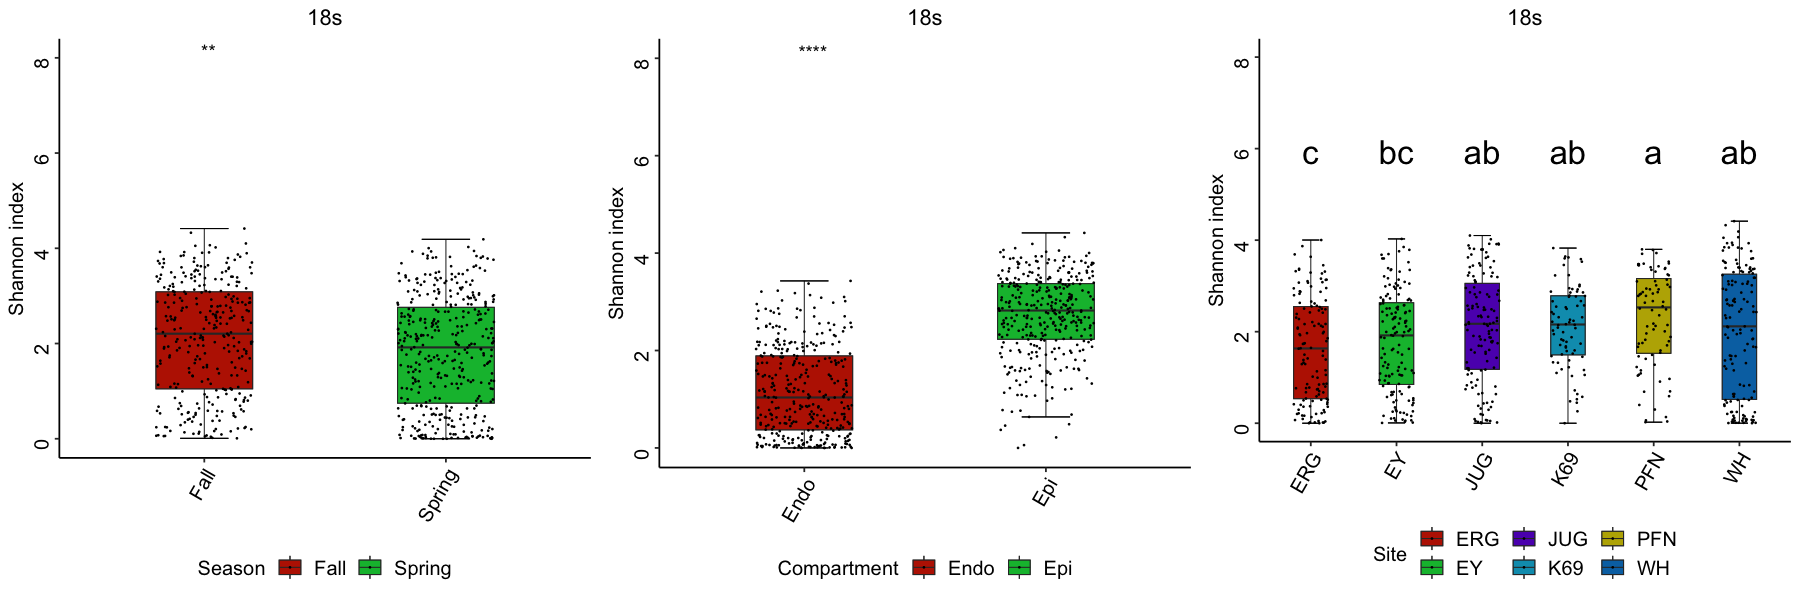

In [20]:
#--------------------------------------------------------------------
#PV9
Otu1 = read.table("data/DataClean/PV9Otu.txt", header = T , check.names = F , stringsAsFactors = F)
rownames(Otu1) = Otu1$Samplenumber
n = which(colnames(Otu1)=='Otu00002') 
n
#---------------------------`------------------------------------------------------------------
sam_otu = Otu1[-c(1:14)] #n-1
sam_otu = sam_otu[rowSums(sam_otu)!=0,]
sample = Otu1[c(1:14)] #n-1
sample = sample[rownames(sample) %in% rownames(sam_otu),]
identical(row.names(sample),row.names(sam_otu)) 
#make phyloseq input files

#otu-sample matrix
#phloseqfiles
otusam <- otu_table(sam_otu , taxa_are_rows = FALSE,errorIfNULL = TRUE)
samples <- sample_data(sample)
file <- phyloseq(otusam,samples)
#---------------------------------------------------------------------------------------------
#alphadiversity bacteria]

rich = estimate_richness(file,measures = c("Observed", "Chao1", "Shannon"))
rich = select(rich , -c(3))
rich1 = merge(rich,data.frame(sample_data(file)),by=0)
rich1 = select(rich1 , -c(1))
rich_sample = rich1
rich_sample$Groups = paste(rich_sample$Compartment , rich_sample$Season , sep = "_")
rich_sample$Groups = as.factor(rich_sample$Groups)
ggdensity(rich_sample$Shannon) #not normal
shapiro.test(rich_sample$Shannon) #not normal
####with letter final
counter = 6
variable = c("Season" , 'Compartment')
for (i in 1: length(variable)){
  counter = counter + 1
  var = variable[i]
  Div = "Shannon"
  p <- ggplot( rich_sample, aes_string(x = var , y = Div , fill=var))  + 
    geom_boxplot( outlier.shape=NA ,width=0.4 , lwd = 0.3 , 
                  position = position_dodge(width=6))  +
    stat_boxplot(aes(ymin = ..lower.., ymax = ..upper..) ,outlier.shape=NA ,width=0.4 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymin = ..ymax..), width=0.2 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymax = ..ymin..) ,width=0.2,lwd = 0.3) +
    geom_jitter(alpha = 1 , color = "black" , position = position_jitter(width = 0.2) , size = 0.1) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 12), 
          axis.text.y = element_text(angle=90, hjust=1 , size = 12 , colour="black" ) , 
          axis.title.y =  element_text(angle=90, size = 12) ,
          axis.title.x = element_blank() ,
          legend.position="bottom",
          legend.title = element_text(colour="black", size=12),
          legend.text = element_text(colour="black", size=12),
          plot.title = element_text(hjust = 0.5)) + ylim(-0.002,8) + 
    stat_compare_means(label = "p.signif", method = "wilcox.test") +
    scale_fill_manual(values = color) + labs(title="18s", y = "Shannon index")
  plot_list[[counter]] = p 
}

DT = dunnTest(Shannon ~ as.factor(Site),data=rich_sample,method="bh") 
PT = DT$res
PT
group_data <- cldList(P.adj ~ Comparison,
                      data = PT,
                      threshold = 0.05 , reverse = 'TRUE') 
group_data

group_data$max = max(rich_sample$Shannon + 1)
colnames(group_data) = c("Site","Letter", "MonoLetter", "max")

variable = c("Site")
for (i in 1: length(variable)){
  counter = counter + 1
  var = variable[i]
  Div = "Shannon"
  p <- ggplot( rich_sample, aes_string(x = var , y = Div , fill=var))  + 
    geom_boxplot( outlier.shape=NA ,width=0.4 , lwd = 0.3 , 
                  position = position_dodge(width=6))  +
    stat_boxplot(aes(ymin = ..lower.., ymax = ..upper..) ,outlier.shape=NA ,width=0.4 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymin = ..ymax..), width=0.2 , lwd = 0.3) +
    stat_boxplot(geom = "errorbar", aes(ymax = ..ymin..) ,width=0.2,lwd = 0.3) +
    geom_jitter(alpha = 1 , color = "black" , position = position_jitter(width = 0.2) , size = 0.1) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1 , colour="black", size = 12), 
          axis.text.y = element_text(angle=90, hjust=1 , size = 12 , colour="black" ) , 
          axis.title.y =  element_text(angle=90, size = 12) ,
          axis.title.x = element_blank() ,
          legend.position="bottom",
          legend.title = element_text(colour="black", size=12),
          legend.text = element_text(colour="black", size=12),
          plot.title = element_text(hjust = 0.5)) + ylim(-0.002,8) + 
    geom_text(data=group_data,aes(x=Site,y=max,label=Letter),position = position_dodge(width = 0.9), size = 7 , vjust=-0.5 ) +
    scale_fill_manual(values = color) + labs(title="18s", y = "Shannon index")
  plot_list[[counter]] = p 
}


options(repr.plot.width=15, repr.plot.height=5)
print('Eukaryotes alpha diversity plots')
grid.arrange(grobs = plot_list[c(7:9)], nrow = 1, ncol = 3 , align="hv" )

null device 
          1

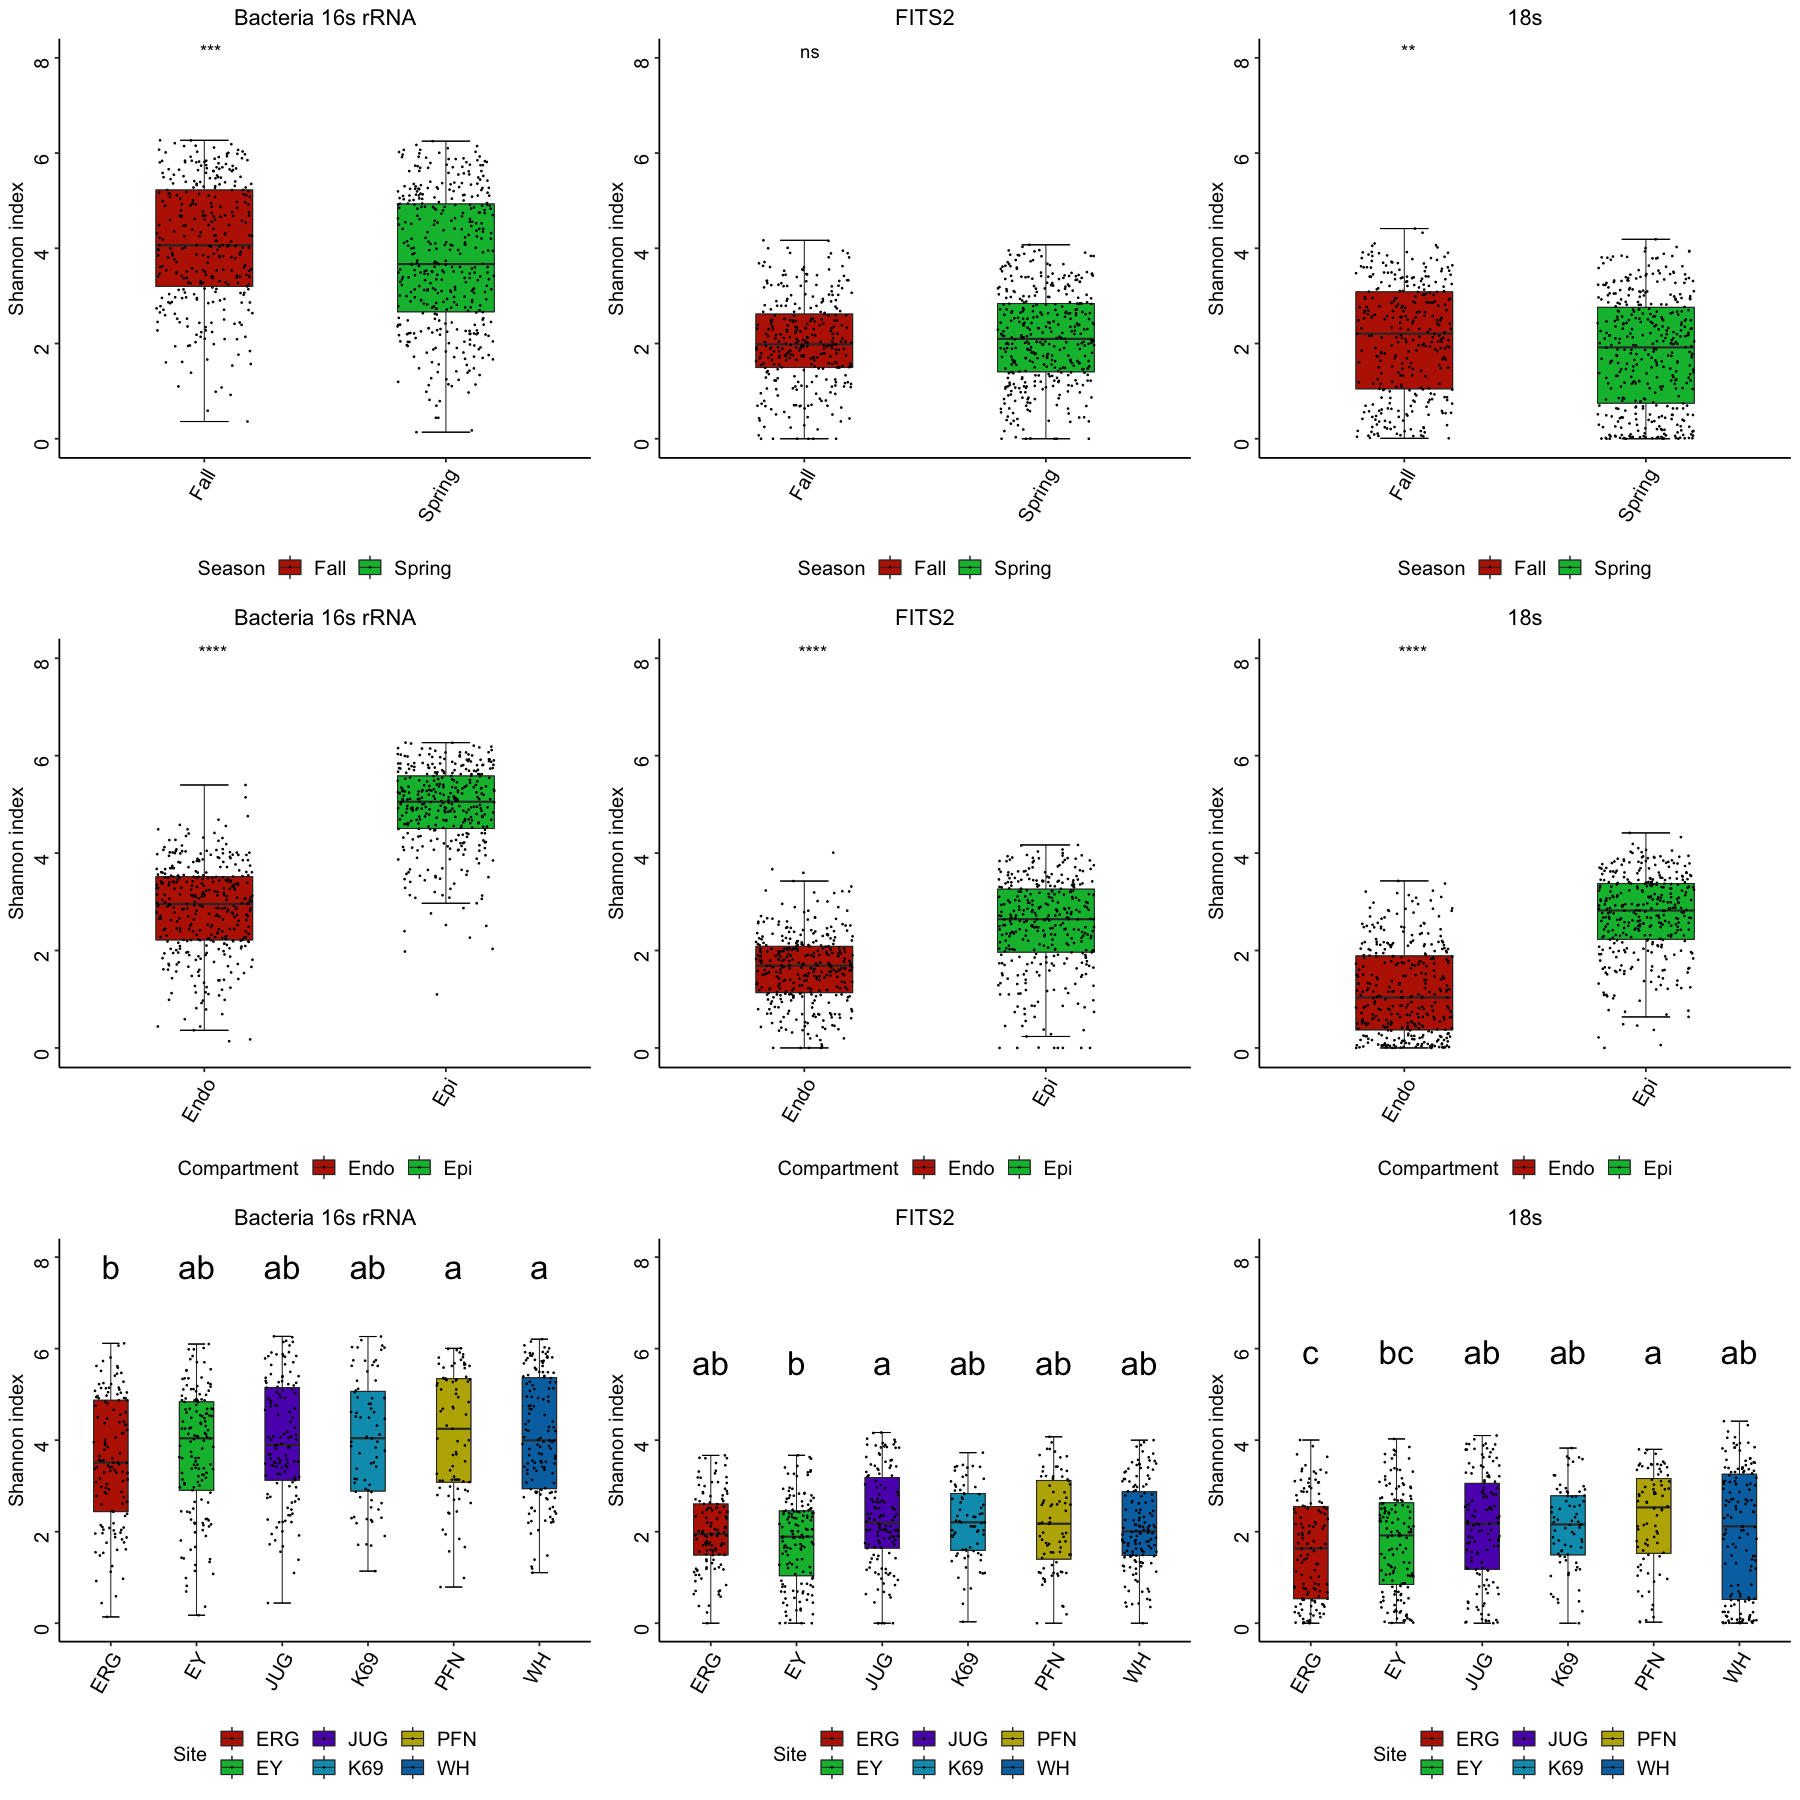

In [21]:
options(repr.plot.width=15, repr.plot.height=15)
ggsave("plots/alpha_diversty.pdf",grid.arrange(grobs = plot_list[c(1,4,7,2,5,8,3,6,9)], nrow = 3, ncol = 3 , align="hv" ), width = 13 , height = 15)
dev.off()